In [1]:
import numpy as np
import xarray as xr
import os 
import cartopy.crs as ccrs
import matplotlib.pyplot as plt 
import matplotlib.colors as clr 
from matplotlib.ticker import SymmetricalLogLocator
import glob
import geopandas as gpd
import regionmask
import cftime

plt.rcParams['savefig.facecolor']='white'


In [4]:
os.chdir('/home/ayhwong/fs03_storage/GCHP_run/shipping/production/')

with xr.open_dataset('baseline/OutputDir/GEOSChem.AerosolMass.20190701_0000z.nc4')['PM25'][0,0,:,:] as ar:
    #Prepare area array
    R = 6368 * 1000 * 100 #in cm
    dlat = np.deg2rad(2)
    dlon = np.deg2rad(2.5)
    area = xr.ones_like(ar) * R * dlat
    # Calculate area for each lat band
    for i,lat in enumerate(area.lat):
        area[i,:] = area[i,:] * R * np.cos(np.deg2rad(lat)) * dlon

    # No negative plz
    area[0,:] = area[1,:]
    area[90,:] = area[89,:]

In [5]:
### get baseline
with xr.open_dataset('baseline/OutputDir/PM25_MDA8_annual_mean.nc') as f:
    pm25_baseline = f['PM25']
    o3_baseline = f['MDA8-O3']

### Compute diff
pm25_diff = {}
o3_diff = {}

for sce in glob.glob('scenario_*')[:-1]:
    target_path = sce +'/OutputDir/PM25_MDA8_annual_mean.nc'
    if os.path.isfile(target_path):
        with xr.open_dataset(target_path) as f:
            pm25_diff[sce] = f['PM25'] - pm25_baseline
            o3_diff[sce] = (f['MDA8-O3'] - o3_baseline)*1e9

with xr.open_dataset('baseline_low_NOx/OutputDir/PM25_MDA8_annual_mean.nc') as f:
    pm25_diff['baseline_low_NOx'] = f['PM25'] - pm25_baseline
    o3_diff['baseline_low_NOx'] = (f['MDA8-O3'] - o3_baseline)*1e9
    
with xr.open_dataset('baseline_no_paranox/OutputDir/PM25_MDA8_annual_mean.nc') as f:
    with xr.open_dataset('scenario_4_no_paranox/OutputDir/PM25_MDA8_annual_mean.nc') as f1:
        pm25_diff_no_paranox = f1['PM25'] - f['PM25'] 
        o3_diff_no_paranox = (f1['MDA8-O3'] - f['MDA8-O3'])*1e9
    

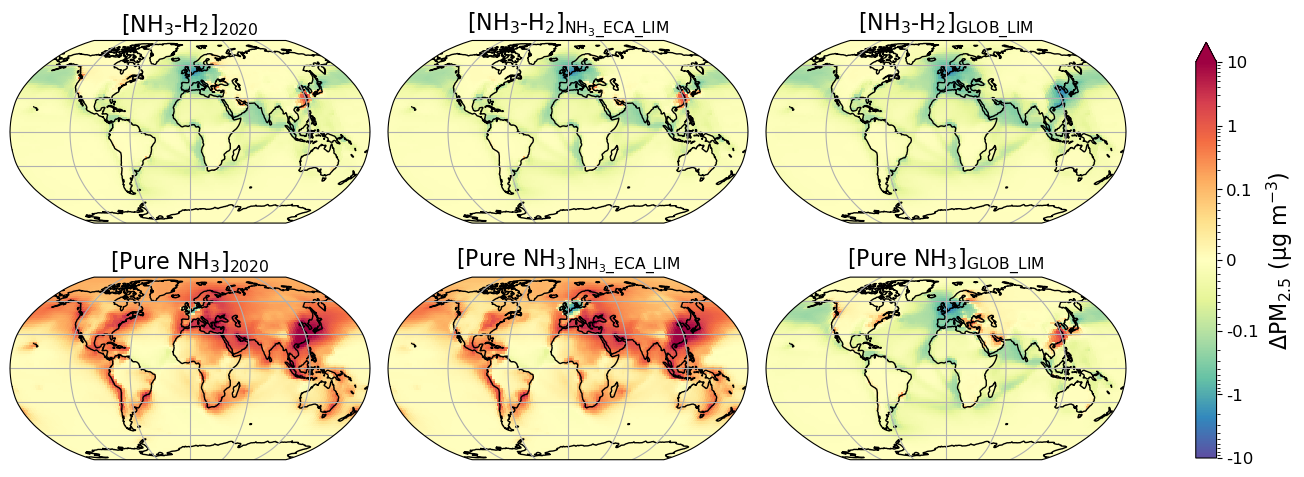

In [6]:
norm = clr.SymLogNorm(linthresh = 0.1, vmax = 10, vmin = -10)
fig, axes = plt.subplots(nrows=2,ncols=3, figsize = (18,6), subplot_kw=dict(projection=ccrs.Robinson()))
subtitle = [r'[$\rm NH_{3}$-$\rm H_{2}$$]_{2020}$',r'[$\rm NH_{3}$-$\rm H_{2}$$\rm ]_{NH_3\_ECA\_LIM}$',r'[$\rm NH_{3}$-$\rm H_{2}$$\rm ]_{GLOB\_LIM}$',r'[Pure $\rm NH_{3}$$]_{2020}$',r'[Pure $\rm NH_{3}$$\rm ]_{NH_3\_ECA\_LIM}$',r'[Pure $\rm NH_{3}$$\rm ]_{GLOB\_LIM}$']

plt.subplots_adjust(hspace = 0.05,wspace = 0.05) 
for i,ax in enumerate(axes.flatten()):
    scn = 'scenario_'+str(i+1)
    ax.set_global()
    ax.coastlines()
    ax.gridlines()
    im = pm25_diff[scn].plot(ax= ax,transform = ccrs.PlateCarree(),norm=norm,cmap = 'Spectral_r',add_colorbar = False)
    ax.set_title(subtitle[i],fontsize=16)

cbar = fig.colorbar(im,ax=axes.ravel().tolist(),shrink = 0.9,extend = 'max')
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks(ticks=[-10,-1,-0.1,0,0.1,1,10],labels=[-10,-1,-0.1,0,0.1,1,10],minor = False)
cbar.set_ticks([-9,-8,-7,-6,-5,-4,-3,-2,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.09,-0.08,-0.07,-0.06,-0.05,-0.04,-0.03,-0.02,-0.01,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,2,3,4,5,6,7,8,9],minor = True)
cbar.set_label(r'$\Delta$$\rm PM_{2.5}$ ($\rm \mu$g $\rm m^{-3}$)',fontsize = 16)
fig.set_rasterized(rasterized=True)

#fig.show()
#plt.savefig('/home/ayhwong/fs03_storage/analysis_plot_script/delta_PM25.png',bbox_inches='tight',dpi = 300,facecolor ='white')
#plt.savefig('/home/ayhwong/fs03_storage/analysis_plot_script/delta_PM25.pdf',bbox_inches='tight',format = 'pdf',dpi = 300,facecolor ='white')
plt.savefig('/home/ayhwong/fs03_storage/analysis_plot_script/delta_PM25.eps',bbox_inches='tight',format = 'eps',dpi = 150,facecolor ='white')

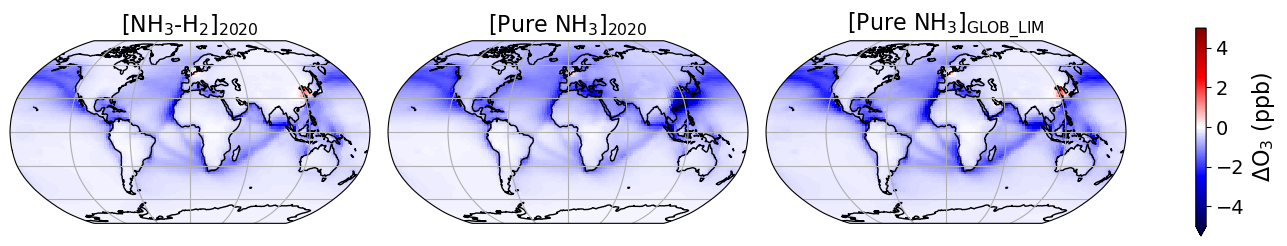

In [7]:
## Plot ozone
norm = clr.TwoSlopeNorm(vcenter=0 , vmax=5 , vmin=-5)
fig, axes = plt.subplots(nrows = 1, ncols = 3,subplot_kw={'projection':ccrs.Robinson()},figsize = (18,3))
plt.subplots_adjust(hspace = 0.05,wspace = 0.05) 

subtitle = [r'[$\rm NH_{3}$-$\rm H_{2}$$\rm ]_{2020}$',r'[Pure $\rm NH_{3}$$\rm ]_{2020}$',r'[Pure $\rm NH_{3}$$\rm ]_{GLOB\_LIM}$']
scn = ['scenario_1','scenario_4','scenario_6']
for i,ax in enumerate(axes.flat):
    ax.set_global()
    ax.coastlines()
    ax.gridlines()
    im = o3_diff[scn[i]].plot(ax= ax,transform = ccrs.PlateCarree(),norm=norm,cmap = 'seismic',add_colorbar = False)
    ax.set_title(subtitle[i],fontsize = 16)
    

cbar = fig.colorbar(im,ax=axes.ravel().tolist(),shrink = 0.9,extend = 'min')
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\Delta$$\rm O_{3}$ (ppb)',fontsize = 16)

#emis_maps = [emis_crack_scr,emis_crack_scramox_eca,emis_crack_scramox,emis_pure_eca_scr,emis_pure_eca_scramox,emis_pure_scramox]
    #emis = emis_maps[i].NOx * grid_area * 365.25*24*60*60
fig.set_rasterized(rasterized=True)

#plt.savefig('/home/ayhwong/fs03_storage/analysis_plot_script/delta_O3.png',bbox_inches='tight',dpi = 300,facecolor ='white')
#plt.savefig('/home/ayhwong/fs03_storage/analysis_plot_script/delta_O3.pdf',bbox_inches='tight',format = 'pdf',dpi = 300,facecolor ='white')
plt.savefig('/home/ayhwong/fs03_storage/analysis_plot_script/delta_O3.eps',bbox_inches='tight',format = 'eps',dpi = 150,facecolor ='white')

In [ ]:
### Plot PARANOX

with xr.open_dataset('baseline_no_paranox/OutputDir/PM25_MDA8_annual_mean.nc') as f:
    pm25_baseline_no_paranox = f['PM25']
    o3_baseline_no_paranox = f['MDA8-O3']

with xr.open_dataset('scenario_4_no_paranox/OutputDir/PM25_MDA8_annual_mean.nc') as f:
    pm25_diff_no_paranox = f['PM25'] - pm25_baseline_no_paranox
    o3_diff_no_paranox = (f['MDA8-O3'] - o3_baseline_no_paranox)*1e9
    

#cbar_levels = [-8,-6,-5,-4,-3,-2,-1,-0.5,-0.25,0.25,0.5,1,2,3,4,5,6,8]
norm = clr.TwoSlopeNorm(vcenter=0 , vmax=5 , vmin=-5)
#cbar_levels = np.linspace(-8,8,100)
fig, axes = plt.subplots(nrows=1,ncols=2, figsize = (13,3), subplot_kw=dict(projection=ccrs.Robinson()))
plt.subplots_adjust(hspace = 0.05,wspace = 0.05) 

delta_delta_o3 = o3_diff_no_paranox -  o3_diff['scenario_4']
delta_delta_pm25 = pm25_diff_no_paranox - pm25_diff['scenario_4']

norm = clr.TwoSlopeNorm(vcenter=0 , vmax=5 , vmin=-5)
axes[0].set_global()
axes[0].coastlines()
axes[0].gridlines()
im = delta_delta_o3.plot(ax= axes[0],transform = ccrs.PlateCarree(),norm=norm,cmap = 'bwr',add_colorbar = False)
axes[0].set_title(r'Difference in $\Delta$$O_{3}$')
cbar = fig.colorbar(im,shrink = 0.7)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('ppb',fontsize = 14)


norm = clr.SymLogNorm(linthresh=0.1,vmax = 10, vmin = -10)
axes[1].set_global()
axes[1].coastlines()
axes[1].gridlines()
im = delta_delta_pm25.plot(ax= axes[1],transform = ccrs.PlateCarree(),norm=norm,cmap = 'Spectral_r',add_colorbar = False)
axes[1].set_title(r'Difference in $\Delta$$PM_{2.5}$')
cbar = fig.colorbar(im,shrink = 0.7)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$\mu$g $m^{-3}$',fontsize = 14)

plt.savefig('/home/ayhwong/fs03_storage/analysis_plot_script/delta_no_paranox.png',bbox_inches='tight',dpi = 300,facecolor ='white')
plt.savefig('/home/ayhwong/fs03_storage/analysis_plot_script/delta_no_paranox.pdf',bbox_inches='tight',format = 'pdf',dpi = 300,facecolor ='white')
plt.savefig('/home/ayhwong/fs03_storage/analysis_plot_script/delta_no_paranox.eps',bbox_inches='tight',format = 'eps',dpi = 300,facecolor ='white')

In [34]:
### Look at composition changes
baseline_filelist = [os.path.join('baseline/OutputDir/',x) for x in os.listdir('baseline/OutputDir/') if 'GEOSChem.SpeciesConc.2019' in x]
scenario_1_filelist = [os.path.join('scenario_1/OutputDir/',x) for x in os.listdir('scenario_1/OutputDir/') if 'GEOSChem.SpeciesConc.2019' in x]
#scenario_4_filelist = [os.path.join('scenario_4/OutputDir/',x) for x in os.listdir('scenario_4/OutputDir/') if 'GEOSChem.SpeciesConc.2019' in x]


aer_baseline = xr.open_mfdataset(baseline_filelist)
aer_scenario_1 = xr.open_mfdataset(scenario_1_filelist)
#aer_scenario_4 = xr.open_mfdataset(scenario_4_filelist)

#test.close()


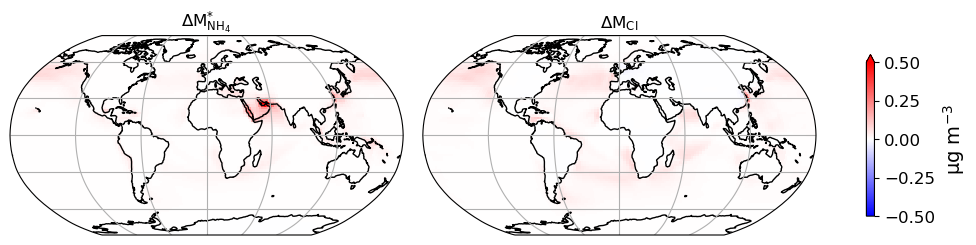

In [77]:
### Look at ion imbalance

delta_nh4 = aer_scenario_1.SpeciesConc_NH4.sel(lev = 1).mean(dim='time') - aer_baseline.SpeciesConc_NH4.sel(lev = 1).mean(dim='time')
delta_nit = aer_scenario_1.SpeciesConc_NIT.sel(lev = 1).mean(dim='time') - aer_baseline.SpeciesConc_NIT.sel(lev = 1).mean(dim='time')
delta_so4 = aer_scenario_1.SpeciesConc_SO4.sel(lev = 1).mean(dim='time') - aer_baseline.SpeciesConc_SO4.sel(lev = 1).mean(dim='time')

ion_imbalance = delta_nh4 - delta_nit - 2 * delta_so4
mass_imbalance = 1.1 * 18 /0.024 * ion_imbalance * 1e6

delta_salacl = aer_scenario_1.SpeciesConc_SALACL.sel(lev = 1).mean(dim='time') - aer_baseline.SpeciesConc_SALACL.sel(lev = 1).mean(dim='time')
delta_salacl = 1.86 * 35.453 /0.024 * delta_salacl * 1e6

#cbar_levels = np.linspace(-8,8,100)
fig, axes = plt.subplots(nrows=1,ncols=2, figsize = (13,3), subplot_kw=dict(projection=ccrs.Robinson()))
plt.subplots_adjust(hspace = 0.05,wspace = 0.05) 
norm = clr.TwoSlopeNorm(vcenter=0 , vmax=0.5 , vmin=-0.5)

axes[0].set_global()
axes[0].coastlines()
axes[0].gridlines()
im = mass_imbalance.plot(ax= axes[0],transform = ccrs.PlateCarree(),norm = norm, cmap = 'bwr',add_colorbar = False)
axes[0].set_title(r'$\Delta$$\rm M^{*}_{NH_{4}}$')


axes[1].set_global()
axes[1].coastlines()
axes[1].gridlines()
im = delta_salacl.plot(ax= axes[1],transform = ccrs.PlateCarree(),norm = norm, cmap = 'bwr',add_colorbar = False)
axes[1].set_title(r'$\Delta$$\rm M_{Cl}$')

cbar = fig.colorbar(im,ax=axes.ravel().tolist(),shrink = 0.7,extend = 'max')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$\rm \mu$g $\rm m^{-3}$',fontsize = 14)

plt.savefig('/home/ayhwong/fs03_storage/analysis_plot_script/nh4_imbalace.png',bbox_inches='tight',dpi = 300,facecolor ='white')
plt.savefig('/home/ayhwong/fs03_storage/analysis_plot_script/nh4_imbalace.pdf',bbox_inches='tight',format = 'pdf',dpi = 300,facecolor ='white')
plt.savefig('/home/ayhwong/fs03_storage/analysis_plot_script/nh4_imbalace.eps',bbox_inches='tight',format = 'eps',dpi = 300,facecolor ='white')

In [4]:
def get_ndep(scenario):
    
    N_frac_wetdep = [14/105.06,14/63,14/215,14/145.13,28/192.15,14/147.15,14/147.15,14/147.15,14/147.15,14/163.15,14/163.15,1,14/163.15,14/188.91,14/195.15,14/197.17,14/149.11,14/149.11,1,14/215.28,14/215.28,14/147.1,14/93.05,14/149.12,14/17.04,14/18.05,14/62,14/31.4,14/121.06,14/135.08]
    N_species_drydep = ['ClNO3','BrNO3','ETHLN','ETNO3','HNO3','HONIT','ICN','IDN','IHN1','IHN2','IHN3','IHN4','INPB','INPD','IONITA','IONO','IONO2','IPRNO3','ITCN','ITHN','MCRHN','MCRHNB','MENO3','MONITA','MONITS','MONITU','MPAN','MVKN','N2O5','NH3','NH4','NIT','NITs','NO2','NPRNO3','PAN','PPN','PROPNN','PRPN']
    N_species_wetdep = ['ETHLN','HNO3','HONIT','ICN','IDN','IHN1','IHN2','IHN3','IHN4','INPB','INPD','IONITA','IONO','IONO2','ITCN','ITHN','MCRHN','MCRHNB','MONITA','MONITS','MONITU','MPAN','MPN','MVKN','NH3','NH4','NIT','NITs','PAN','PPN']

    with xr.open_dataset('baseline/OutputDir/GEOSChem.DryDep.20190701_0000z.nc4') as f:
        ndep = xr.zeros_like(f['DryDep_O3'][0,:,:])

    #Prepare area array
    R = 6368 * 1000 * 100 #in cm
    dlat = np.deg2rad(2)
    dlon = np.deg2rad(2.5)
    area = xr.ones_like(ndep) * R * dlat
    # Calculate area for each lat band
    for i,lat in enumerate(area.lat):
        area[i,:] = area[i,:] * R * np.cos(np.deg2rad(lat)) * dlon

    # No negative plz
    area[0,:] = area[1,:]
    area[90,:] = area[89,:]

    N_A = 6.02e23
    time_factor = 365.25 * 24 * 60 * 60
    
    with xr.open_dataset(scenario+'/OutputDir/GEOSChem.DryDep.20190701_0000z.nc4') as f:
        for s in N_species_drydep:
            v = 'DryDep_' + s
            if s in ['DHDN','N2O5']:
                ndep = ndep + f[v][0,:,:] / N_A * area * time_factor * 28
            else:
                ndep = ndep + f[v][0,:,:] / N_A * area * time_factor * 14
        
    #Add wetdep on top    
    with xr.open_dataset(scenario+'/OutputDir/GEOSChem.WetLossConv.20190701_0000z.nc4') as f1:
        with xr.open_dataset(scenario+'/OutputDir/GEOSChem.WetLossLS.20190701_0000z.nc4') as f2:
            for i,s in enumerate(N_species_wetdep):
                wc_v = 'WetLossConv_'+s
                wl_v = 'WetLossLS_'+s
                ndep = ndep + (f1[wc_v]+ f2[wl_v]).sum(dim = ['time','lev']) * time_factor * N_frac_wetdep[i] * 1000

    ## Convert to kg per hectare
    ndep_by_area = ndep / 1000 / area * 1e8
    
    out = {'ndep_g_yr':ndep,'ndep_kg_hectare':ndep_by_area}
    return(out)

In [7]:
ndep_scenarios = {}
ndep_diff_by_area = {}
ndep_diff_total = {}
for i in np.arange(1,7):
    s = 'scenario_'+str(i)
    ndep_scenarios[s] = get_ndep(s)
    ndep_diff_by_area[s] = ndep_scenarios[s]['ndep_kg_hectare'] - ndep_baseline['ndep_kg_hectare']
    ndep_diff_total[s] = ndep_scenarios[s]['ndep_g_yr'] - ndep_baseline['ndep_g_yr']

In [47]:
### Find OMZ

ocean_oxygen = xr.open_dataset('/home/ayhwong/fs03_storage/ocean_data/oxygen/netcdf/all/1.00/ocean_oxygen_regridded.nc',decode_times=False)
ocean_oxygen_min = ocean_oxygen.min(dim='depth').o_an[0,:,:]
omz_mask = xr.ones_like(test).where(test < 20)


In [ ]:
#cbar_levels = [-8,-6,-5,-4,-3,-2,-1,-0.5,-0.25,0.25,0.5,1,2,3,4,5,6,8]
norm_test = clr.TwoSlopeNorm(vcenter=0 , vmax=10 , vmin=-10)
#cbar_levels = np.linspace(-8,8,100)
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines()
ax.gridlines()
ndep_diff_by_area['scenario_4'].plot(ax= ax,transform = ccrs.PlateCarree(),norm=norm_test,cbar_kwargs={'shrink':0.7})
plt.title('$\Delta$ $N_{dep}$ from Scenario 4')

In [38]:
### Separate increased ndep into land and ocean component
landfrac = xr.open_dataset('/home/ayhwong/ExtData/GEOS_2x2.5/MERRA2/2015/01/MERRA2.20150101.CN.2x25.nc4')['FRLAND'][0,:,:]


In [49]:
ndep_ocean = (ndep_diff_total['scenario_4'] * (1-landfrac))
ndep_omz_sum = ndep_ocean.where(ocean_oxygen_min < 20).sum(skipna=True)
ndep_non_omz_sum = ndep_ocean.where(ocean_oxygen_min >= 20).sum(skipna=True) 
n2o_co2_equiv_from_ndep = (ndep_omz_sum * 0.01 + ndep_non_omz_sum* 0.0001) /14*44 * 273/1e12
print(n2o_co2_equiv_from_ndep)

<xarray.DataArray ()>
array(45.6900795)
Coordinates:
    time     float64 706.5


In [9]:
### Use regional pop-weighted changes to do the analysis:

country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
mask_gc = country_mask.mask_3D(pm25_diff['scenario_1'])
mask_region = regionmask.defined_regions.giorgi.mask_3D(pm25_diff['scenario_1'])
population = xr.load_dataarray('/home/ayhwong/fs03_storage/GPW_population/gpw_population_count_2x25_gcgrid.nc')[4,:,:].fillna(0)
pm25_baseline = xr.load_dataset('/home/ayhwong/fs03_storage/GCHP_run/shipping/production/baseline/OutputDir/PM25_MDA8_annual_mean.nc')['PM25']

In [27]:
population_weighted_avg = o3_diff['scenario_5'].weighted(mask_gc * population).mean(('lat','lon'),skipna=True).to_dataframe()


                      abbrevs                     names       PM25
time       lev region                                             
2019-01-01 1.0 0           FJ                      Fiji   0.062925
               1           TZ                  Tanzania   0.030425
               2           WS                 W. Sahara   0.028670
               3           CA                    Canada   0.728237
               4           US  United States of America   0.352760
               5           KZ                Kazakhstan   0.323437
               6           UZ                Uzbekistan   0.545236
               7           PG          Papua New Guinea   0.232078
               8         INDO                 Indonesia   2.734662
               9           AR                 Argentina   0.157057
               10          CL                     Chile   0.801285
               11         DRC           Dem. Rep. Congo   0.054845
               12          SO                   Somalia   0.03

In [29]:
population_weighted_avg = pm25_baseline.weighted(mask_region * population).mean(('lat','lon'),skipna=True).to_dataframe()
print(population_weighted_avg.to_string())

                      abbrevs                   names       PM25
time       lev region                                           
2019-01-01 1.0 1          AUS               Australia  13.764529
               2          AMZ            Amazon Basin   8.597129
               3          SSA  Southern South America   9.335609
               4          CAM         Central America  12.876712
               5          WNA   Western North America   4.815449
               6          CNA   Central North America   7.947522
               7          ENA   Eastern North America   8.689553
               8          ALA                  Alaska   9.004477
               9          GRL               Greenland   4.545690
               10         MED     Mediterranean Basin  22.964062
               11         NEU         Northern Europe  16.984212
               12         WAF          Western Africa  48.268173
               13         EAF          Eastern Africa  22.216533
               14        

In [35]:
population_weighted_avg_baseline = pm25_baseline.weighted(mask_region * population).mean(('lat','lon'),skipna=True).to_dataframe()
population_weighted_avg_delta = pm25_diff['scenario_6'].weighted(mask_region * population).mean(('lat','lon'),skipna=True).to_dataframe()
population_weighted_avg_delta.PM25 / population_weighted_avg_baseline.PM25 *100

time        lev  region
2019-01-01  1.0  1        -0.031972
                 2        -0.040133
                 3        -0.020746
                 4        -0.039195
                 5         4.212195
                 6        -0.287487
                 7         0.832245
                 8         0.172672
                 9        -2.399323
                 10       -0.459600
                 11       -5.188878
                 12       -0.181736
                 13       -0.131208
                 14       -0.007483
                 15        0.186159
                 16       -0.035888
                 17        1.181247
                 18       -0.127809
                 19       -0.002922
                 20       -0.040757
                 21        0.138210
Name: PM25, dtype: float64

In [25]:
population_weighted_avg = pm25_baseline.weighted(mask_gc * population).mean(('lat','lon'),skipna=True).to_dataframe()
print(population_weighted_avg.to_string())

                      abbrevs                     names        PM25
time       lev region                                              
2019-01-01 1.0 0           FJ                      Fiji    1.951381
               1           TZ                  Tanzania    8.680522
               2           WS                 W. Sahara  119.317783
               3           CA                    Canada    8.202006
               4           US  United States of America    7.541830
               5           KZ                Kazakhstan   18.980218
               6           UZ                Uzbekistan   34.581334
               7           PG          Papua New Guinea    4.470670
               8         INDO                 Indonesia   25.293364
               9           AR                 Argentina    5.299098
               10          CL                     Chile    6.167919
               11         DRC           Dem. Rep. Congo   24.474531
               12          SO                   

In [171]:
population_weighted_avg = o3_diff['scenario_6'].weighted(mask_region * population).mean(('lat','lon'),skipna=True).to_dataframe()
print(population_weighted_avg.to_string())

                      abbrevs                   names   MDA8-O3
time       lev region                                          
2019-01-01 1.0 1          AUS               Australia -0.612864
               2          AMZ            Amazon Basin -0.733500
               3          SSA  Southern South America -0.495350
               4          CAM         Central America -0.699703
               5          WNA   Western North America -0.700589
               6          CNA   Central North America -0.452831
               7          ENA   Eastern North America -0.440459
               8          ALA                  Alaska -0.718590
               9          GRL               Greenland -0.506856
               10         MED     Mediterranean Basin -0.816237
               11         NEU         Northern Europe -0.273261
               12         WAF          Western Africa -0.588065
               13         EAF          Eastern Africa -0.379586
               14         SAF         So

In [21]:
population_weighted_avg_baseline = pm25_baseline.weighted(mask_region * population).mean(('lat','lon'),skipna=True).to_dataframe()
population_weighted_avg_delta = pm25_diff['scenario_4'].weighted(mask_region * population).mean(('lat','lon'),skipna=True).to_dataframe()
population_weighted_avg_delta.PM25 / population_weighted_avg_baseline.PM25 *100

In [24]:
population_weighted_avg_delta.PM25 / population_weighted_avg_baseline.PM25 *100

time        lev  region
2019-01-01  1.0  1          4.355798
                 2          5.112584
                 3          9.905511
                 4          5.300760
                 5         24.831059
                 6          7.494276
                 7         21.676575
                 8          6.358425
                 9          4.907988
                 10        14.630547
                 11         4.336712
                 12         0.276810
                 13         0.385695
                 14         3.233746
                 15         5.540615
                 16        14.240133
                 17        21.231387
                 18         0.839785
                 19         1.307625
                 20         0.354803
                 21         5.874456
Name: PM25, dtype: float64